In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import contourpy
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from _FigureJiazeHelper import *
from _DetectabilityWithMeta import *
from _CommunityDetect import *
from EXPERIMENT_MINORITY import *
from scipy.optimize import linear_sum_assignment

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=10)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 10  # 'large'
plt.rcParams['lines.markersize'] = 12
plt.rcParams['axes.linewidth'] = 0.5

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [3]:
def cm_for_network(delta, rho, n, d, Z_s, Z_b):
#     delta = 0.005
#     rho = 0.1
    pout = d / n - ((1-rho)**2 / Z_b + rho**2 / Z_s) * delta
    pin = pout + delta
    pin = 0 if pin < 1e-10 else pin
    pout = 0 if pout < 1e-10 else pout
    ps = (pin - pout) * np.identity(q) + pout * np.ones((q, q))
    n_f = int(n * (Z_s + Z_b) * (Z_b * rho + Z_s * (1 - rho)) / (Z_s * Z_b))
    rho_f = Z_b * rho / (Z_b * rho + Z_s * (1 - rho))
    n_fq = int(n_f / q)
    n_f = int(n_fq * q)
    sizes = [[n_fq] * Z_s, [n_fq] * Z_b]
    msbm = MetaSBM(n_f, rho_f, ps, sizes)
    A = msbm.sample()
    subA, subGroupId = msbm.filter(A, metaId=0)
    subTrueNumgroup = np.size(np.unique(subGroupId))
    subBHpartition, subBHNumgroup = CommunityDetect(subA).BetheHessian()
    print(f'True Sub Group Number is {subTrueNumgroup}')
    print(f'BH Sub Group Number is {subBHNumgroup}')
    confusionMatrix, _ = get_confusionmatrix(subGroupId, subBHpartition, subTrueNumgroup, subBHNumgroup)
    np.set_printoptions(suppress = True)
    print(f'rho is {rho}, AMI is {adjusted_mutual_info_score(subGroupId, subBHpartition)}, Confusion Matrix is\n {confusionMatrix}')
    fig = plt.figure(figsize=(4, 4))
    widths = [4]
    heights = [4]
    spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
    row = 0
    col = 0
    ax = fig.add_subplot(spec5[row, col])
    c = gen_colors(start=colors_red[0], end=colors_blue[0], n=6)
    _, indexes, counts = np.unique(subGroupId, return_index=True, return_counts=True)
    counts = counts[np.argsort(indexes)]
    plot_block_matrix(subA.toarray(), partition_names=list(range(6)), partition_counts=counts, colors=c, ms=0.01)
    return confusionMatrix

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [37]:
def plot_cm(confusionMatrix, rho, delta, fig=None, ax=None):
    subTrueNumgroup,subBHNumgroup = np.shape(confusionMatrix)
    rowsum = np.sum(confusionMatrix, axis=1)
    rowsum = rowsum.reshape(-1, 1)
    rowsum = np.repeat(rowsum, subBHNumgroup, axis=1)
    normConfusionMatrix = np.round(confusionMatrix / rowsum, 2)
    if fig is None and ax is None:
        fig = plt.figure(figsize=(3, 3))
        widths = [4]
        heights = [4]
        spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
        row = 0
        col = 0
        ax = fig.add_subplot(spec5[row, col])
#     cmap = mpl.colormaps["bwr_r"]
#     cmap = mpl.colormaps["RdYlBu"]
    cmap = mpl.colormaps["seismic_r"]
    cmap = truncate_colormap(cmap, 0.3, 0.7)
    im = ax.matshow(normConfusionMatrix, cmap=cmap, vmin=0, vmax=1)
    for i in range(subTrueNumgroup):
        for j in range(subBHNumgroup):
            c = normConfusionMatrix[i,j]
            ax.text(j, i, str(c), va='center', ha='center', fontsize=12)
#     ax.set_title(rf"$\rho={rho}, \delta={delta}$", fontsize=12)
    # ax.set_ylabel("True Community", rotation='horizontal', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    return im

In [6]:
# For big n
n = 6000
d = 50
Z_s = 1
Z_b = 2
q = Z_s + Z_b
Withlambda = True
givenNumGroup = False
DC = False
BP = False
fileID = 'amiExp24.1.9' + f'_n={n}_q={q}_d={round(d)}_{"lambda" if Withlambda else ""}_'\
                              f'{"givenNumGroup" if givenNumGroup else ""}_' \
                              f'{"DC" if DC else ""}_fixsubparameter'
load_path = "./result/detectabilityWithMeta/" + fileID + ".txt"
addfileId = 'amiExp24.1.10' + f'_n={n}_q={q}_d={round(d)}_{"lambda" if Withlambda else ""}_'\
                              f'{"givenNumGroup" if givenNumGroup else ""}_' \
                              f'{"DC" if DC else ""}_fixsubparameter_more'
addload_path = "./result/detectabilityWithMeta/" + addfileId + ".txt"
plot_rhos, plot_zs, sub_ami, sub_num_group, lambdas = read_exp(load_path=load_path, Withlambda=Withlambda, exclude_rho=[0, 1], add_path=addload_path)

3


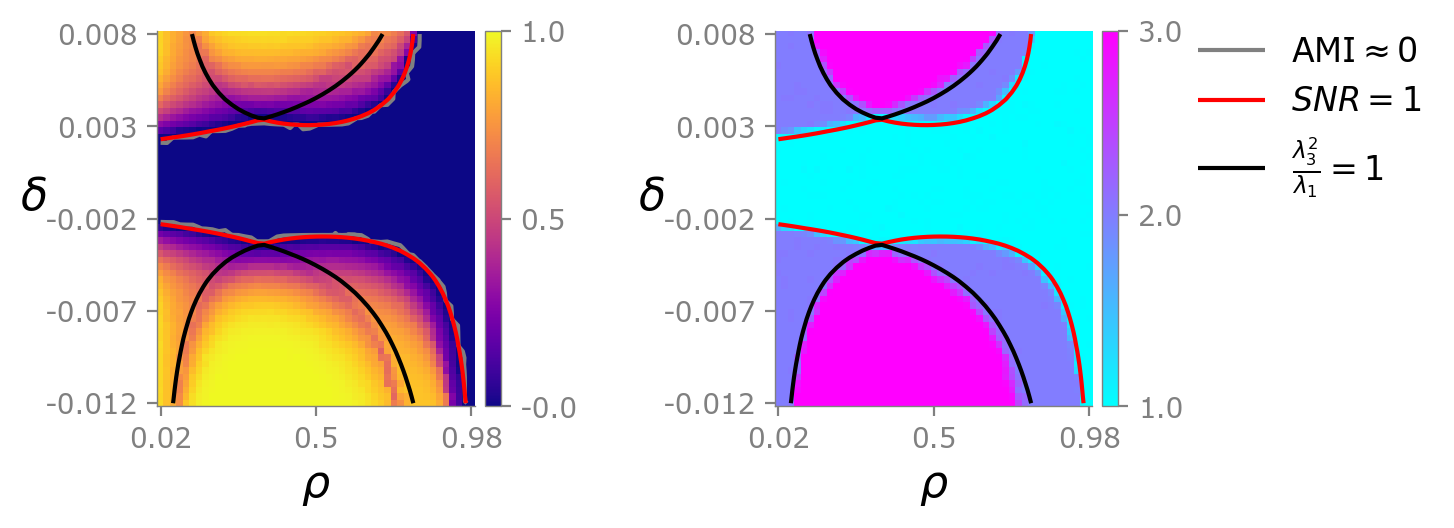

In [27]:
# figsize (width, height) with inch, 1 inch = 72 pt
fig = plt.figure(figsize=(6.2, 3))
widths = [3, 3]
heights = [3]
spec5 = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
cmap = mpl.colormaps["plasma"]
zcenter = 0.5
plot_subami = color_imshow_2d(plot_rhos, plot_zs, sub_ami, z_center=zcenter, title="", xlabel=r'$\rho$', ylabel=r'$\delta$', cmap=cmap, ax=ax, fig=fig, ytickprecision=3)
# ax.set_xlabel(r'$\rho$', fontsize=20)
handels = []
handels += contour_data(plot_subami, ax, levels=[1e-3], fmt={1e-3: r'AMI$\simeq$0'}, color='gray', inline=False)
plot_snrm = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 1]**2/lambdas[:, 0], z_center=1, return_gridz=True)
# plot_l4overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 3]**2/lambdas[:, 0], z_center=1, return_gridz=True)
plot_l3overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 2]**2/lambdas[:, 0], z_center=1, return_gridz=True)
handels += contour_data(plot_snrm, ax, levels=[1], fmt={1: r'$SNR=1$'}, color='red', inline=False)
# handels += contour_data(plot_l4overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_4^2}{\lambda_1}=1$'}, color='green', inline=False)
handels += contour_data(plot_l3overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_3^2}{\lambda_1}=1$'}, color='black', inline=False)
row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
cmap = mpl.colormaps["cool"]
plot_subnumgroup = color_imshow_2d(plot_rhos, plot_zs, sub_num_group, z_center=2, title="", xlabel=r'$\rho$', ylabel=r'$\delta$', cmap=cmap, ax=ax, fig=fig, vmax=3, ytickprecision=3)
# plot_l4overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 3]**2/lambdas[:, 0], z_center=1, return_gridz=True)
plot_l3overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 2]**2/lambdas[:, 0], z_center=1, return_gridz=True)
plot_snrm = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 1]**2/lambdas[:, 0], z_center=1, return_gridz=True)
contour_data(plot_snrm, ax, levels=[1], fmt={1: r'$SNR=1$'}, color='red', inline=False)
# contour_data(plot_l4overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_4^2}{\lambda_1}=1$'}, color='green', inline=False)
contour_data(plot_l3overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_3^2}{\lambda_1}=1$'}, color='black', inline=False)
lgd = fig.legend(handels, [r'AMI$\approx$0', r'$SNR=1$', r'$\frac{\lambda_3^2}{\lambda_1}=1$', r'$\frac{\lambda_4^2}{\lambda_1}=1$'], 
           loc=2, bbox_to_anchor=(0.94, 0.85),  fontsize=12, markerscale=2, frameon=False)
plt.subplots_adjust(wspace=0.8)
save_path = "./_Figure/Minority/" + "FigureMinorityAMISNR_" + f'Z_s{Z_s}Z_b{Z_b}' + ".pdf"
# plt.tight_layout()
plt.savefig(save_path, dpi=600, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [13]:
print(np.unique(plot_rhos))
print(np.unique(plot_zs))

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98]
[-1.250e-02 -1.213e-02 -1.177e-02 -1.140e-02 -1.104e-02 -1.067e-02
 -1.031e-02 -9.940e-03 -9.580e-03 -9.210e-03 -8.850e-03 -8.480e-03
 -8.110e-03 -7.750e-03 -7.380e-03 -7.020e-03 -6.650e-03 -6.290e-03
 -5.920e-03 -5.560e-03 -5.190e-03 -4.820e-03 -4.460e-03 -4.090e-03
 -3.730e-03 -3.360e-03 -3.000e-03 -2.630e-03 -2.270e-03 -1.900e-03
 -1.540e-03 -1.170e-03 -8.000e-04 -4.400e-04 -7.000e-05  2.900e-04
  6.600e-04  1.020e-03  1.390e-03  1.750e-03  2.120e-03  2.490e-03
  2.850e-03  3.220e-03  3.580e-03  3.950e-03  4.310e-03  4.680e-03
  5.040e-03  5.410e-03  5.770e-03  6.140e-03  6.510e-03  6.870e-03
  7.240e-03  7.600e-03  7.970e-03  8.330e-03]


Metadata generation done!
number of groups = 2
True Sub Group Number is 3
BH Sub Group Number is 2
True index is [1 2], Community detected index is [0 1]
rho is 0.06, AMI is 0.7522276174273106, Confusion Matrix is
 [[ 177.  169.]
 [2793.   39.]
 [  32. 2775.]]
Metadata generation done!
number of groups = 3
True Sub Group Number is 3
BH Sub Group Number is 3
True index is [0 1 2], Community detected index is [1 0 2]
rho is 0.3, AMI is 0.6516686590550775, Confusion Matrix is
 [[1647.   79.  103.]
 [ 113. 1874.   87.]
 [ 102.   91. 1888.]]
Metadata generation done!
number of groups = 2
True Sub Group Number is 3
BH Sub Group Number is 2
True index is [0 1], Community detected index is [0 1]
rho is 0.7, AMI is 0.3999959871659774, Confusion Matrix is
 [[3647.  530.]
 [  80.  837.]
 [  89.  800.]]
Metadata generation done!
number of groups = 2
True Sub Group Number is 3
BH Sub Group Number is 2
True index is [1 2], Community detected index is [1 0]
rho is 0.06, AMI is 0.8154912737251587, Con

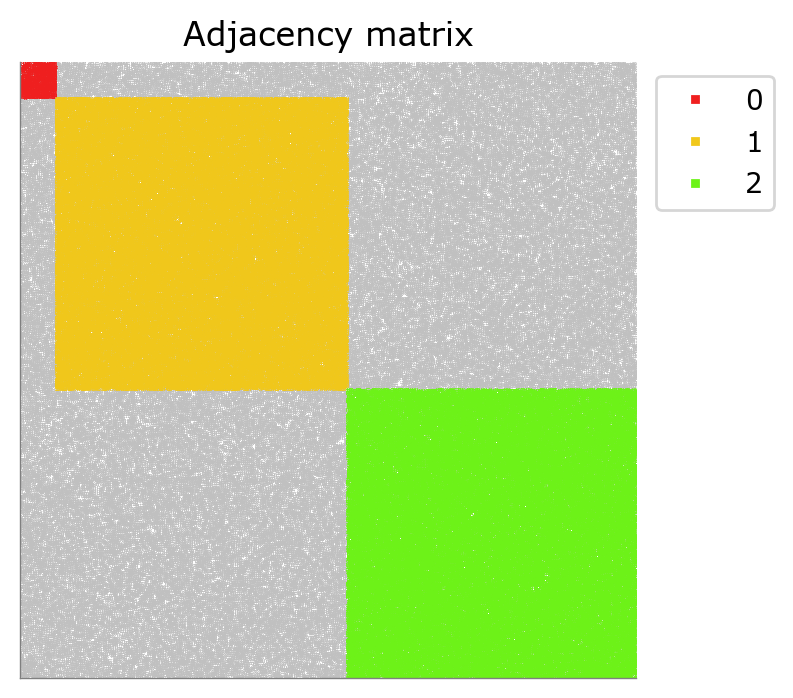

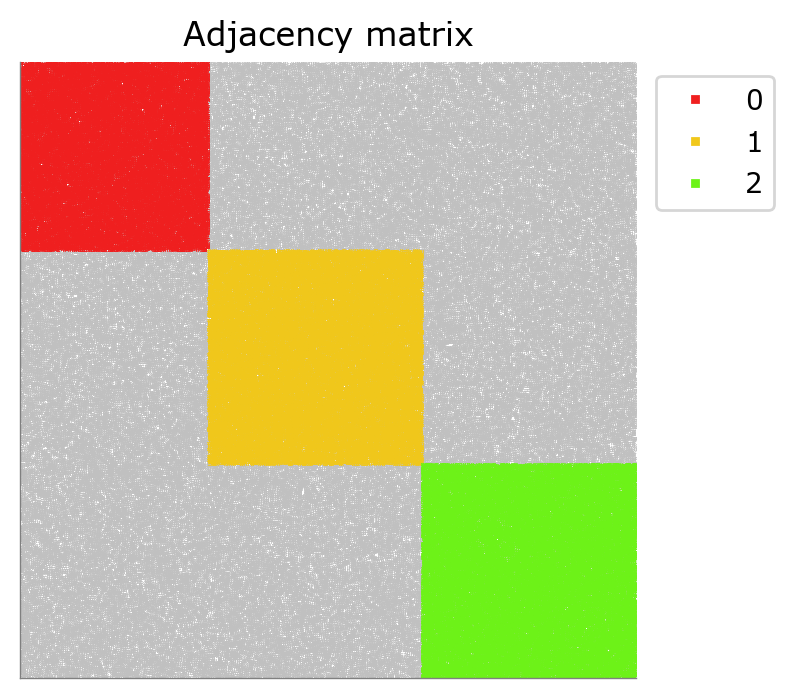

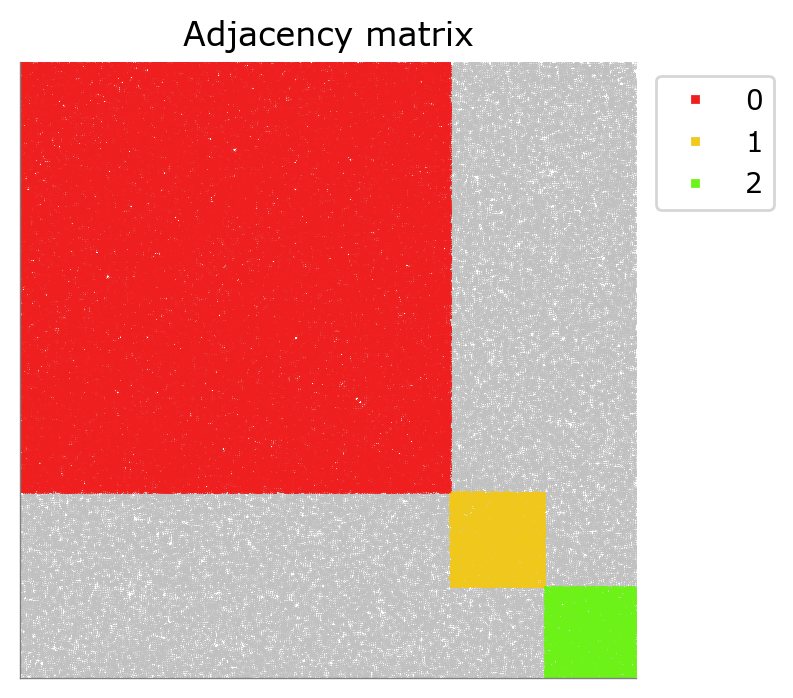

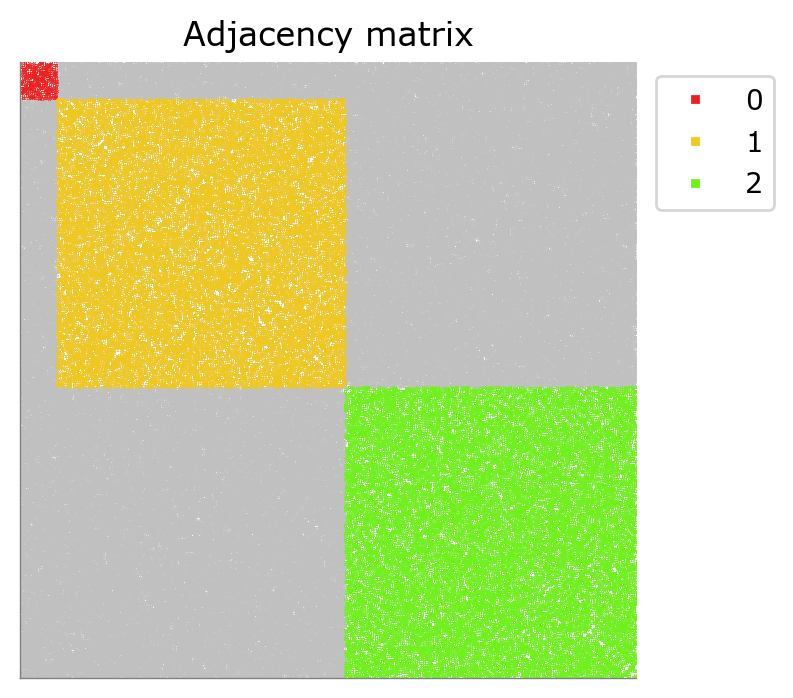

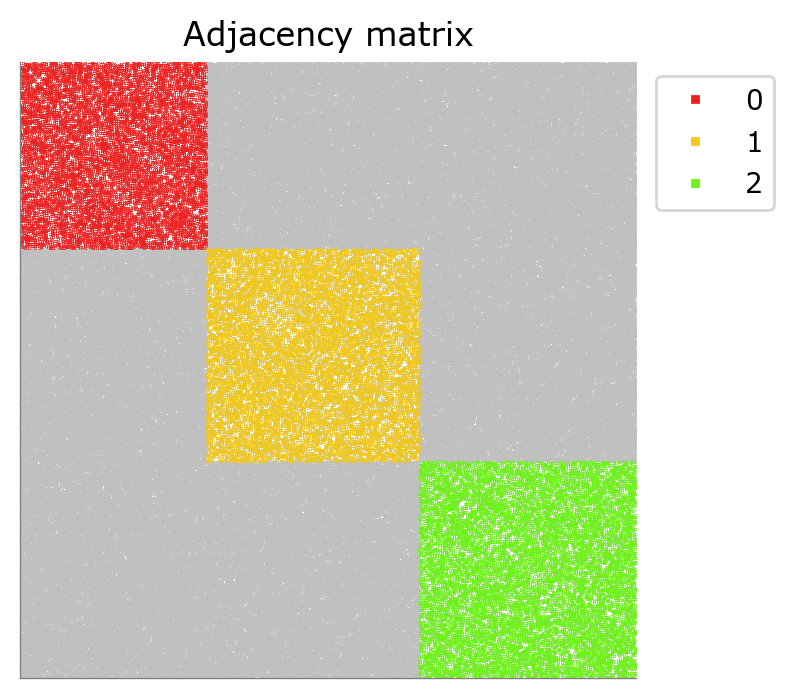

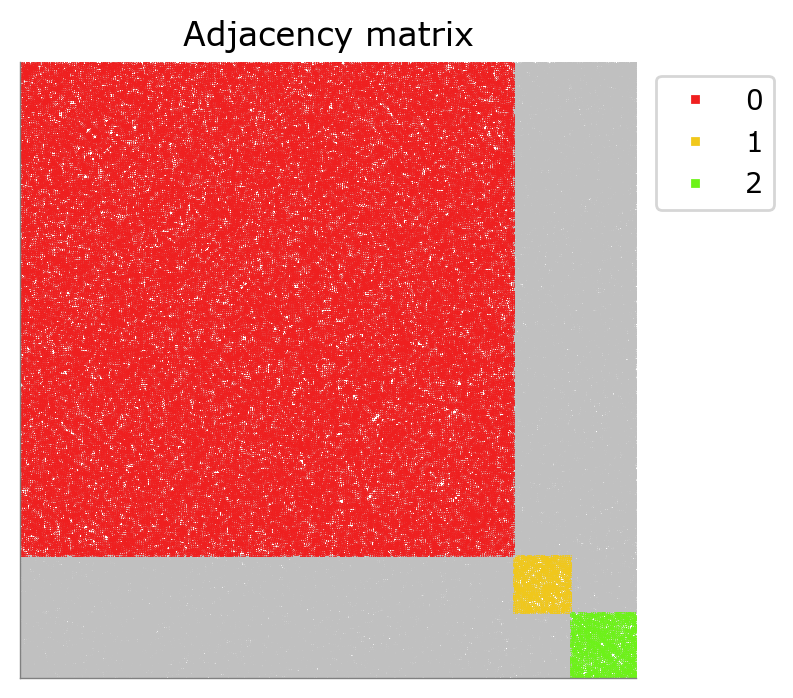

In [29]:
delta=0.006
rho=0.06
cm1 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.006
rho=0.3
cm2 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.006
rho=0.7
cm3 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.007
rho=0.06
cm4 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.007
rho=0.3
cm5 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.007
rho=0.8
cm6 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

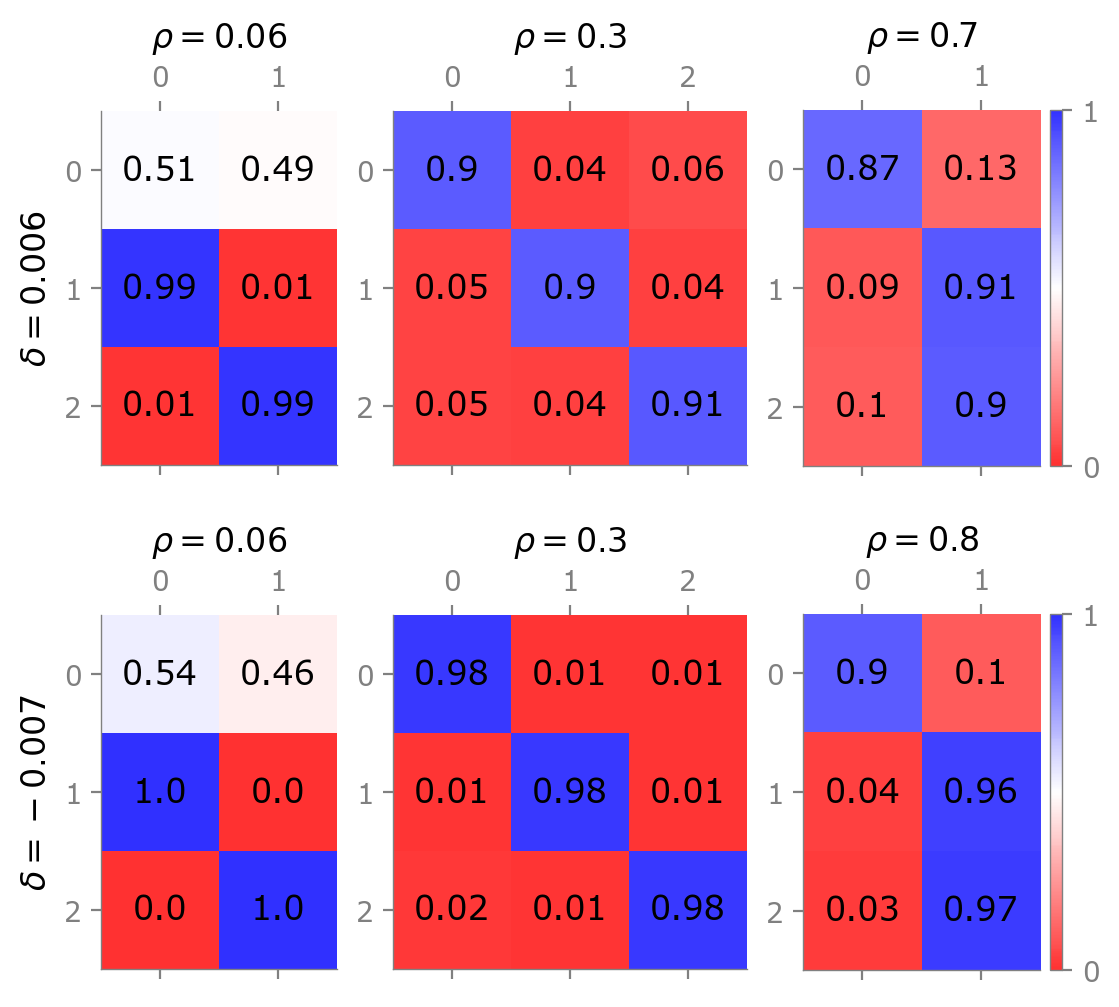

In [41]:
fig = plt.figure(figsize=(6.2, 6))
widths = [2, 3, 2.2]
heights = [3, 3]
spec5 = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
delta=0.006
rho=0.06
_ = plot_cm(confusionMatrix=cm1, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)
ax.set_ylabel(rf"$\delta={delta}$", rotation='vertical', fontsize=12)

row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
delta=0.006
rho=0.3
_ = plot_cm(confusionMatrix=cm2, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 0
col = 2
ax = fig.add_subplot(spec5[row, col])
delta=0.006
rho=0.7
im = plot_cm(confusionMatrix=cm3, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# cticks = [0, 0.25, 0.5, 0.75, 1]
cticks = [0, 1]
clabels = ["0", "1"]
cbar = fig.colorbar(im, cax=cax, ticks=cticks)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_yticklabels(clabels)

row = 1
col = 0
ax = fig.add_subplot(spec5[row, col])
delta=-0.007
rho=0.06
_ = plot_cm(confusionMatrix=cm4, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)
ax.set_ylabel(rf"$\delta={delta}$", rotation='vertical', fontsize=12)

row = 1
col = 1
ax = fig.add_subplot(spec5[row, col])
delta=-0.007
rho=0.3
_ = plot_cm(confusionMatrix=cm5, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 1
col = 2
ax = fig.add_subplot(spec5[row, col])
delta=-0.007
rho=0.8
im = plot_cm(confusionMatrix=cm6, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# cticks = [0, 0.25, 0.5, 0.75, 1]
cticks = [0, 1]
clabels = ["0", "1"]
cbar = fig.colorbar(im, cax=cax, ticks=cticks)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_yticklabels(clabels)
save_path = "./_Figure/Minority/" + "FigureMinorityCM_" + f'Z_s{Z_s}Z_b{Z_b}' + ".pdf"
# plt.tight_layout()
plt.savefig(save_path, dpi=600)